# I. Очистка и подготовка данных

**Цель ноутбука:**

- загрузить исходные данные,
- привести данные к корректным типам,
- провести проверку качества данных,
- удалить аномалии, выбросы, избавить от пропусков,
- создать новые признаки для дальнейшего анализа,
- проверить бизнес-логику,
- сохранить очищенный датасет.

### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
sns.set_theme(style='darkgrid', palette='deep')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

In [4]:
path = '../data/raw/kicksharing.csv'
df = pd.read_csv(path)

In [5]:
# потребление памяти по столбцам (в байтах)
df.memory_usage(deep=True)

Index                           132
order_rk                    3173992
party_rk                    3173992
gender_cd                  19784872
age                         3173992
education_level_cd         16497148
marital_status_cd          17050548
lvn_state_nm               34998359
minute_cost                 3173992
activation_cost             3173992
hold_amount                 3173992
transport_model            20319570
distance_km                 3173992
created_dttm               29756175
book_start_dttm            29756175
book_end_dttm              29756175
book_time_zone_cd           3173992
local_book_start_dttm      29756175
nominal_price_rub_amt       3173992
loyalty_accrual_rub_amt     3173992
loyalty_accrual_bns_amt     3173992
dtype: int64

In [6]:
# общее потребление памяти (в Мб)
df.memory_usage(deep=True).sum() / (2 ** 20)

np.float64(250.42461490631104)

Просмотрим данные:

In [7]:
df.head(3)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.115,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.516,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN


Файл содержит следующие данные: информацию о пользователях, стоимости поездок и характеристиках самокатов.

In [8]:
# отсортируем записи по времени начала поездки

df = df.sort_values(by='book_start_dttm').reset_index(drop=True)
df

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47.000000,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,NaN,NaN
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51.000000,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,NaN,NaN
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17.000000,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,NaN
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32.000000,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,NaN
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09.000000,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396744,356251715,943691233,M,21,NaN,NaN,NaN,7.99,50.0,300.0,SL,0.660,2024-10-21 17:16:10.000000,2024-10-21 17:16:13.466000,2024-10-21 17:19:41.094329,3,2024-10-21 17:16:13.466000,81.96,NaN,NaN
396745,356251658,221564025,M,27,GRD,UNM,СТАВРОПОЛЬСКИЙ КРАЙ,8.79,50.0,300.0,SL,0.886,2024-10-21 17:16:14.000000,2024-10-21 17:16:16.786000,2024-10-21 17:20:57.616129,3,2024-10-21 17:16:16.786000,93.95,NaN,NaN
396746,356251209,863005623,M,45,GRD,UNM,ВОЛГОГРАДСКАЯ ОБЛ,7.49,40.0,300.0,Max,0.369,2024-10-21 17:17:01.000000,2024-10-21 17:17:05.167000,2024-10-21 17:23:06.640943,3,2024-10-21 17:17:05.167000,84.94,NaN,NaN
396747,356251129,1063772449,M,19,NaN,NaN,РЕСП БУРЯТИЯ,6.49,30.0,300.0,SL,1.072,2024-10-21 17:17:22.000000,2024-10-21 17:17:28.215000,2024-10-21 17:22:54.219545,5,2024-10-21 19:17:28.215000,68.94,NaN,NaN


In [9]:
print(f"Данные охватывают период с {df['book_start_dttm'].min()} по {df['book_start_dttm'].max()}")

Данные охватывают период с 2024-04-07 14:57:01.030814 по 2024-10-21 17:18:07.715000


### Первичный осмотр данных

In [10]:
# размер датасета
df.shape

(396749, 20)

In [11]:
# типы данных
df.dtypes

order_rk                     int64
party_rk                     int64
gender_cd                   object
age                          int64
education_level_cd          object
marital_status_cd           object
lvn_state_nm                object
minute_cost                float64
activation_cost            float64
hold_amount                float64
transport_model             object
distance_km                float64
created_dttm                object
book_start_dttm             object
book_end_dttm               object
book_time_zone_cd            int64
local_book_start_dttm       object
nominal_price_rub_amt      float64
loyalty_accrual_rub_amt    float64
loyalty_accrual_bns_amt    float64
dtype: object

In [12]:
# столбцы
df.columns

Index(['order_rk', 'party_rk', 'gender_cd', 'age', 'education_level_cd',
       'marital_status_cd', 'lvn_state_nm', 'minute_cost', 'activation_cost',
       'hold_amount', 'transport_model', 'distance_km', 'created_dttm',
       'book_start_dttm', 'book_end_dttm', 'book_time_zone_cd',
       'local_book_start_dttm', 'nominal_price_rub_amt',
       'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt'],
      dtype='object')

In [13]:
# информация о датасете
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

In [14]:
# описательная статистика
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,book_time_zone_cd,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
count,3.967e+05,3.967e+05,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,396749.000,366992.000,21948.000
mean,2.892e+08,5.988e+08,31.544,7.289,42.593,299.984,3.681,3.536,127.648,37.516,127.789
std,3.813e+07,3.312e+08,9.435,1.289,11.990,1.939,141.862,1.209,100.122,75.209,496.812
min,2.526e+08,1.472e+04,12.000,1.500,0.000,80.000,0.000,0.000,0.000,-161.940,1.000
25%,2.618e+08,2.962e+08,24.000,6.490,30.000,300.000,0.941,3.000,80.840,11.240,43.000
50%,2.704e+08,6.110e+08,31.000,7.490,50.000,300.000,1.730,3.000,103.940,18.730,62.000
75%,3.433e+08,8.647e+08,37.000,8.220,50.000,300.000,3.064,3.000,142.100,35.060,81.000
max,3.563e+08,1.301e+09,94.000,19.990,50.000,500.000,56012.640,12.000,5627.640,3185.000,55429.361


In [15]:
# статистика по объектам
df.describe(include=['object'])

,gender_cd,education_level_cd,marital_status_cd,lvn_state_nm,transport_model,created_dttm,book_start_dttm,book_end_dttm,local_book_start_dttm
count,393828,190059,217729,362572,396749,396749,396749,396749,396749
unique,2,5,5,212,14,387224,396745,396749,396746
top,M,GRD,UNM,Г МОСКВА,SL,2024-08-12 16:37:14.000000,2024-09-17 13:44:24.183000,2024-04-07 15:00:26.432310,2024-09-17 13:44:24.183000
freq,335458,94341,116094,90897,241247,4,2,1,2


In [16]:
# количество уникальных значений в каждом столбце
df.nunique()

order_rk                   396749
party_rk                    64052
gender_cd                       2
age                            77
education_level_cd              5
marital_status_cd               5
lvn_state_nm                  212
minute_cost                   547
activation_cost                10
hold_amount                     3
transport_model                14
distance_km                384385
created_dttm               387224
book_start_dttm            396745
book_end_dttm              396749
book_time_zone_cd              13
local_book_start_dttm      396746
nominal_price_rub_amt       16713
loyalty_accrual_rub_amt     18483
loyalty_accrual_bns_amt      1858
dtype: int64

**Краткая сводка:**

- размер датасета: 396749 строк, 20 колонок,
- найдены аномалии (`distance_km.max() = 56012,64`).

### Преобразование типов данных

In [17]:
int_columns = ['age', 'book_time_zone_cd']
for col in int_columns:
    df[col] = df[col].astype('int8')

df[int_columns].dtypes

age                  int8
book_time_zone_cd    int8
dtype: object

In [18]:
float_columns = ['minute_cost', 'activation_cost', 'hold_amount', 'distance_km', 'nominal_price_rub_amt', 'loyalty_accrual_rub_amt', 'loyalty_accrual_bns_amt']

for col in float_columns:
    df[col] = df[col].astype('float32')

df[float_columns].dtypes

minute_cost                float32
activation_cost            float32
hold_amount                float32
distance_km                float32
nominal_price_rub_amt      float32
loyalty_accrual_rub_amt    float32
loyalty_accrual_bns_amt    float32
dtype: object

In [19]:
date_columns = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df[date_columns].dtypes

created_dttm             datetime64[ns]
book_start_dttm          datetime64[ns]
book_end_dttm            datetime64[ns]
local_book_start_dttm    datetime64[ns]
dtype: object

In [20]:
category_columns = ['gender_cd', 'education_level_cd', 'marital_status_cd', 'lvn_state_nm', 'transport_model']

for col in category_columns:
    df[col] = df[col].astype('category')

df[category_columns].dtypes

gender_cd             category
education_level_cd    category
marital_status_cd     category
lvn_state_nm          category
transport_model       category
dtype: object

In [21]:
df.memory_usage(deep=True).sum() / (2 ** 20)

np.float64(31.813060760498047)

Преобразовали типы данных и привели их к корректным форматам.

После оптимизации типов смогли уменьшить занимаемую память на **87.3%**.

### Обработка пропусков и дубликатов

In [22]:
df.isna().sum().sort_values(ascending=False)

loyalty_accrual_bns_amt    374801
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
loyalty_accrual_rub_amt     29757
gender_cd                    2921
order_rk                        0
party_rk                        0
age                             0
hold_amount                     0
activation_cost                 0
minute_cost                     0
distance_km                     0
transport_model                 0
created_dttm                    0
book_start_dttm                 0
book_time_zone_cd               0
book_end_dttm                   0
nominal_price_rub_amt           0
local_book_start_dttm           0
dtype: int64

In [23]:
(df.isna().sum() / len(df) * 100).sort_values(ascending=False).to_frame('Пропуски').style.format('{:.2f}%')

,Пропуски
loyalty_accrual_bns_amt,94.47%
education_level_cd,52.10%
marital_status_cd,45.12%
lvn_state_nm,8.61%
loyalty_accrual_rub_amt,7.50%
gender_cd,0.74%
order_rk,0.00%
party_rk,0.00%
age,0.00%
hold_amount,0.00%


Необходимо обработать пропуски, так как они присутствуют в 6 колонках.

1. Заменим значение NaN на 0 в колонке `loyalty_accrual_bns_amt`, что означает: кэшбэк в бонусах не был начислен (пользователь или не воспользовался кредитной картой, или условия не предусматривали начисления бонусов).
2. Заменим значение NaN на 0 в колонке `loyalty_accrual_rub_amt`, что означает: нулевой кэшбэк в рублях.
3. Добавим категорию U / Unknown в оставшиеся признаки. Данная категория будет означать, что данные не были указаны.

In [24]:
# заменим NaN на 0

df['loyalty_accrual_rub_amt'] = df['loyalty_accrual_rub_amt'].fillna(0)
df['loyalty_accrual_bns_amt'] = df['loyalty_accrual_bns_amt'].fillna(0)

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,0.0,0.0
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,0.0,0.0
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,0.0
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,0.0
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,0.0,0.0


In [25]:
# добавим новую категорию 'U' для пола и заполним ей пропуски

df['gender_cd'] = df['gender_cd'].cat.add_categories('U')
df['gender_cd'] = df['gender_cd'].fillna('U')

df.query("gender_cd == 'U'").head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
449,252636773,744503861,U,53,GRD,MAR,Г МОСКВА,8.99,50.0,300.0,SL,1.183,2024-05-18 11:47:27,2024-05-18 11:47:30.966766,2024-05-18 11:54:30.212063,3,2024-05-18 11:47:30.966766,112.93,16.94,0.0
519,252611729,778540620,U,25,NaN,NaN,КАЛИНИНГРАДСКАЯ ОБЛ,6.99,50.0,300.0,Max,2.469,2024-05-18 18:21:27,2024-05-18 18:21:31.397947,2024-05-18 18:42:52.670447,2,2024-05-18 17:21:31.397947,203.78,30.57,0.0
781,252626007,744503861,U,53,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,SL,0.894,2024-05-20 10:20:49,2024-05-20 10:20:52.891699,2024-05-20 10:27:04.321316,3,2024-05-20 10:20:52.891699,109.43,10.94,0.0
982,252627773,744503861,U,53,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,SL,1.073,2024-05-21 11:35:19,2024-05-21 11:35:23.148911,2024-05-21 11:41:49.904527,3,2024-05-21 11:35:23.148911,109.43,10.94,0.0
1025,252634546,129673267,U,30,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.000,2024-05-21 15:51:14,2024-05-21 15:51:16.904439,2024-05-21 15:51:44.048887,3,2024-05-21 15:51:16.904439,0.00,0.00,0.0


In [26]:
# добавим новую категорию 'Unknown' для оставшихся категориальных признаков

category_columns = ['education_level_cd', 'marital_status_cd', 'lvn_state_nm']

for col in category_columns:
    df[col] = df[col].cat.add_categories('Unknown')
    df[col] = df[col].fillna('Unknown')

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,252632665,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,280.129,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,3,2024-04-07 14:57:01.030814,79.96,0.0,0.0
1,252625610,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,2.120,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,3,2024-04-09 12:23:56.253700,64.98,0.0,0.0
2,252622551,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,496.838,2024-04-09 13:33:17,2024-04-09 13:33:21.237110,2024-04-09 13:42:25.580416,3,2024-04-09 13:33:21.237110,129.90,1.0,0.0
3,252611448,218046530,M,37,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,2708.593,2024-04-09 17:49:32,2024-04-09 17:49:38.672744,2024-04-09 18:06:34.975211,3,2024-04-09 17:49:38.672744,185.83,1.0,0.0
4,252626408,292629240,M,35,UGR,MAR,Г МОСКВА,7.99,50.0,300.0,SL,0.000,2024-04-10 16:41:09,2024-04-10 16:41:13.265475,2024-04-10 16:43:42.462157,3,2024-04-10 16:41:13.265475,73.97,0.0,0.0


In [27]:
df.isna().sum().sort_values(ascending=False)

order_rk                   0
party_rk                   0
gender_cd                  0
age                        0
education_level_cd         0
marital_status_cd          0
lvn_state_nm               0
minute_cost                0
activation_cost            0
hold_amount                0
transport_model            0
distance_km                0
created_dttm               0
book_start_dttm            0
book_end_dttm              0
book_time_zone_cd          0
local_book_start_dttm      0
nominal_price_rub_amt      0
loyalty_accrual_rub_amt    0
loyalty_accrual_bns_amt    0
dtype: int64

Пропущенные значения успешно обработаны.

In [28]:
df.duplicated().sum()

np.int64(0)

In [29]:
df.duplicated(subset=['order_rk']).sum()

np.int64(0)

In [30]:
# проверка на уникальность идентификатора заказа (поездки)

df['order_rk'].nunique() == df.shape[0]

True

### Feature engineering

In [31]:
# длительность поездки в мин

df['trip_duration_min'] = ((df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60).astype('float32')

In [32]:
# средняя скорость в км/ч

df['avg_speed_kmh'] = (df['distance_km'] / df['trip_duration_min'] * 60).astype('float32')

In [33]:
# доля кэшбэка в рублях и в бонусах

df['cashback_rate_rub'] = df['loyalty_accrual_rub_amt'] / df['nominal_price_rub_amt'].astype('float32')
df['cashback_rate_bns'] = df['loyalty_accrual_bns_amt'] / df['nominal_price_rub_amt'].astype('float32')

In [34]:
# час

df['hour'] = df['local_book_start_dttm'].dt.hour.astype('int8')

In [35]:
# день недели (0 - пн, 6 - вс)

df['day_of_week'] = df['local_book_start_dttm'].dt.day_of_week.astype('int8')

In [36]:
# месяц

df['month'] = df['local_book_start_dttm'].dt.month.astype('int8')

In [37]:
df.sample(5)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
255557,274444135,294824399,M,33,GRD,UNM,Г МОСКВА,6.57,50.0,300.0,SL,0.720,2024-09-06 11:00:28,2024-09-06 11:00:32.444000,2024-09-06 11:03:45.412142,3,2024-09-06 11:00:32.444000,76.08,15.22,0.0,3.216,13.423,0.200,0.0,11,4,9
55010,257074516,399125673,M,25,GRD,UNM,РЕСП ТАТАРСТАН,4.99,30.0,300.0,Max,2.199,2024-07-04 17:32:06,2024-07-04 17:32:10.186388,2024-07-04 17:44:23.727563,3,2024-07-04 17:32:10.186388,94.87,9.49,0.0,12.226,10.791,0.100,0.0,17,3,7
332478,349108785,250335914,M,27,Unknown,Unknown,Г МОСКВА,8.79,50.0,300.0,SL,11.749,2024-09-25 14:33:40,2024-09-25 14:33:46.686000,2024-09-25 15:04:51.876674,3,2024-09-25 14:33:46.686000,331.28,37.13,0.0,31.087,22.676,0.112,0.0,14,2,9
355238,351045360,1040237194,M,36,Unknown,UNM,НОВОСИБИРСКАЯ ОБЛ,5.99,30.0,300.0,E,3.897,2024-10-02 10:31:01,2024-10-02 10:31:06.560000,2024-10-02 10:49:46.322144,7,2024-10-02 14:31:06.560000,143.81,16.38,0.0,18.663,12.529,0.114,0.0,14,2,10
201901,270719651,725270965,M,28,Unknown,Unknown,ЧЕЛЯБИНСКАЯ ОБЛ,6.49,30.0,300.0,SL,1.915,2024-08-24 09:23:51,2024-08-24 09:23:53.858697,2024-08-24 09:29:21.770941,7,2024-08-24 13:23:53.858697,68.94,13.79,0.0,5.465,21.023,0.200,0.0,13,5,8


In [38]:
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
count,3.967e+05,3.967e+05,396749.000,396749.000,396749.000,396749.000,396749.000,396749,396749,396749,396749.000,396749,396749.000,396749.000,396749.000,396749.000,396749.000,389820.000,389820.000,396749.000,396749.000,396749.000
mean,2.892e+08,5.988e+08,31.544,7.289,42.593,299.984,3.681,2024-08-18 19:57:21.649821952,2024-08-18 19:57:27.763655168,2024-08-18 20:08:54.222991616,3.536,2024-08-18 20:29:37.922017536,127.648,34.702,7.069,11.441,25.363,0.243,0.057,12.550,2.943,8.081
min,2.526e+08,1.472e+04,12.000,1.500,0.000,80.000,0.000,2024-04-07 14:56:47,2024-04-07 14:57:01.030814,2024-04-07 15:00:26.432310,0.000,2024-04-07 14:57:01.030814,0.000,-161.940,0.000,0.033,0.000,-0.229,0.000,0.000,0.000,4.000
25%,2.618e+08,2.962e+08,24.000,6.490,30.000,300.000,0.941,2024-07-22 05:09:57,2024-07-22 05:10:01.884925952,2024-07-22 05:19:02.033711104,3.000,2024-07-22 05:36:05.428699904,80.840,9.800,0.000,4.763,9.019,0.100,0.000,8.000,1.000,7.000
50%,2.704e+08,6.110e+08,31.000,7.490,50.000,300.000,1.730,2024-08-23 10:44:44,2024-08-23 10:44:48.782873088,2024-08-23 10:56:03.260775936,3.000,2024-08-23 11:26:34.415717120,103.940,17.090,0.000,7.769,12.836,0.150,0.000,13.000,3.000,8.000
75%,3.433e+08,8.647e+08,37.000,8.220,50.000,300.000,3.064,2024-09-16 14:00:40,2024-09-16 14:00:44.200000,2024-09-16 14:13:01.654374912,3.000,2024-09-16 14:33:59.144999936,142.100,32.980,0.000,13.371,17.048,0.286,0.000,17.000,5.000,9.000
max,3.563e+08,1.301e+09,94.000,19.990,50.000,500.000,56012.641,2024-10-21 17:18:04,2024-10-21 17:18:07.715000,2024-10-21 17:23:06.640943,12.000,2024-10-21 21:13:43.199000,5627.640,3185.000,55429.359,715.172,656965.938,2.425,20.788,23.000,6.000,10.000
std,3.813e+07,3.312e+08,9.435,1.289,11.990,1.939,141.862,NaN,NaN,NaN,1.209,NaN,100.122,73.005,120.445,13.175,1904.267,0.247,0.533,5.302,1.944,1.212


### Фильтрация и очистка от выбросов

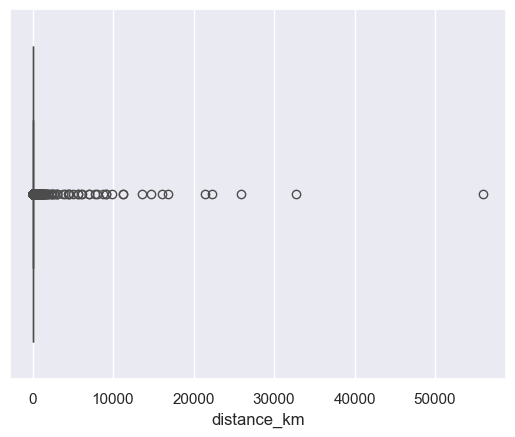

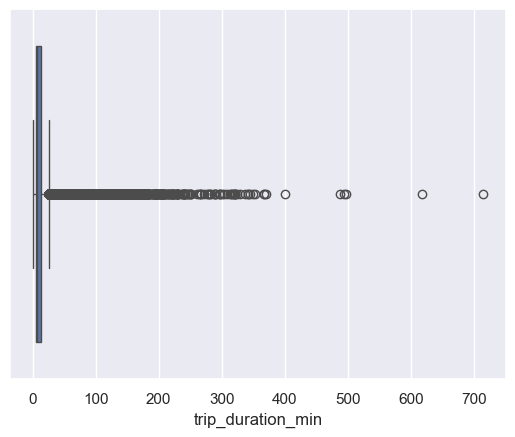

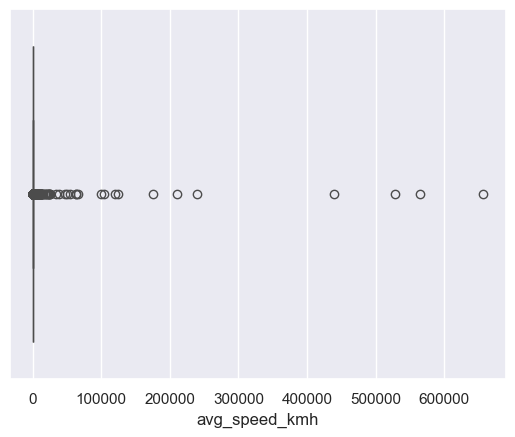

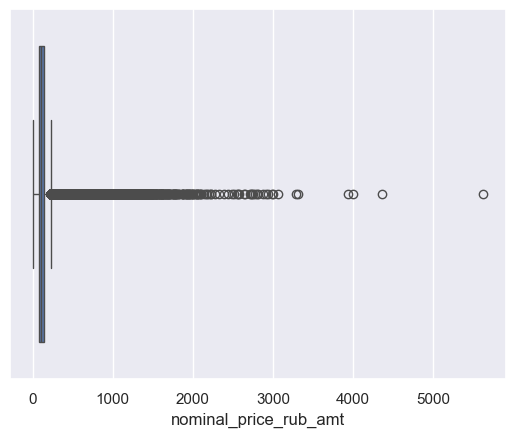

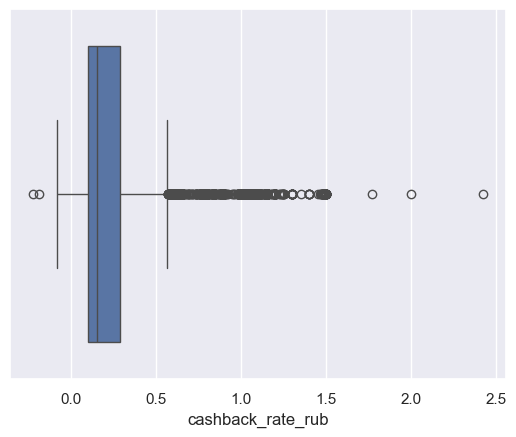

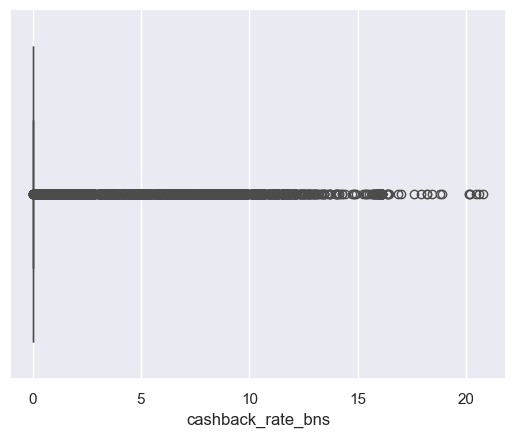

In [39]:
l1 = ['distance_km', 'trip_duration_min', 'avg_speed_kmh', 'nominal_price_rub_amt', 'cashback_rate_rub', 'cashback_rate_bns']

for col in l1:
    sns.boxplot(x = df[col])
    plt.show()

Обнаружены аномальные значения во всех колонках. В `distance_km` и `avg_speed_kmh` скорее всего из-за сбоя GPS.

При очистке важно учитывать редкие, но возможные случаи, чтобы не удалить валидные наблюдения. Для этого следует ограничить диапазон допустимых значений в соответствии с бизнес-логикой.

In [40]:
df = df.copy()

In [41]:
mask = (
        # дистанция от 100 м до 50 км
        (df['distance_km'].between(0.1, 50)) &
        # время поездки от 1 до 180 мин
        (df['trip_duration_min'].between(1, 180)) &
        # средняя скорость от 1 до 30 км/ч
        (df['avg_speed_kmh'].between(1, 30)) &
        # стоимость поездки от 0.1 до 2500 рублей
        (df['nominal_price_rub_amt'].between(0.1, 2500)) &
        # доля кэшбэка в рублях от 0 до 1
        (df['cashback_rate_rub'].between(0, 1)) &
        # доля кэшбэка в бонусах от 0 до 1
        (df['cashback_rate_bns'].between(0, 1))
)

df = df.loc[mask].reset_index(drop=True)
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt,trip_duration_min,avg_speed_kmh,cashback_rate_rub,cashback_rate_bns,hour,day_of_week,month
0,252614779,517007040,M,26,GRD,UNM,Г МОСКВА,7.99,50.0,300.0,SL,0.806,2024-04-17 16:45:16,2024-04-17 16:45:20.641980,2024-04-17 16:51:26.403392,3,2024-04-17 16:45:20.641980,97.94,0.0,0.0,6.096,7.930,0.000,0.0,16,2,4
1,252613066,297828357,M,31,Unknown,UNM,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО,7.99,50.0,300.0,SL,0.238,2024-04-22 15:46:04,2024-04-22 15:46:10.062458,2024-04-22 15:55:04.011996,3,2024-04-22 15:46:10.062458,121.91,1.0,0.0,8.899,1.604,0.008,0.0,15,0,4
2,252621809,145875613,M,35,GRD,DIV,Г МОСКВА,7.99,50.0,300.0,SL,0.282,2024-04-22 15:46:53,2024-04-22 15:47:00.283797,2024-04-22 15:56:28.643724,3,2024-04-22 15:47:00.283797,129.90,1.0,0.0,9.473,1.787,0.008,0.0,15,0,4
3,252632392,328153536,M,25,Unknown,Unknown,Г САНКТ-ПЕТЕРБУРГ,6.99,30.0,300.0,SL,0.303,2024-04-23 06:53:41,2024-04-23 06:53:45.475088,2024-04-23 06:56:59.051051,3,2024-04-23 06:53:45.475088,57.96,0.0,0.0,3.226,5.638,0.000,0.0,6,1,4
4,252633271,517007040,M,26,GRD,UNM,Г МОСКВА,7.49,50.0,300.0,SL,0.823,2024-04-23 09:46:17,2024-04-23 09:46:22.008459,2024-04-23 09:50:38.041837,3,2024-04-23 09:46:22.008459,87.45,0.0,0.0,4.267,11.569,0.000,0.0,9,1,4


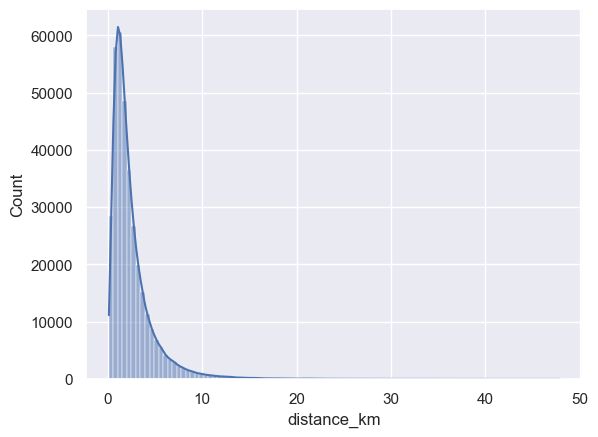

Медиана: 1.802819013595581, среднее: 2.5002617835998535


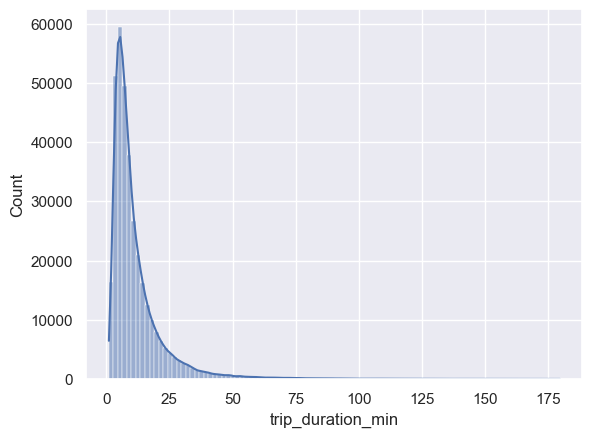

Медиана: 8.140203475952148, среднее: 11.686468124389648


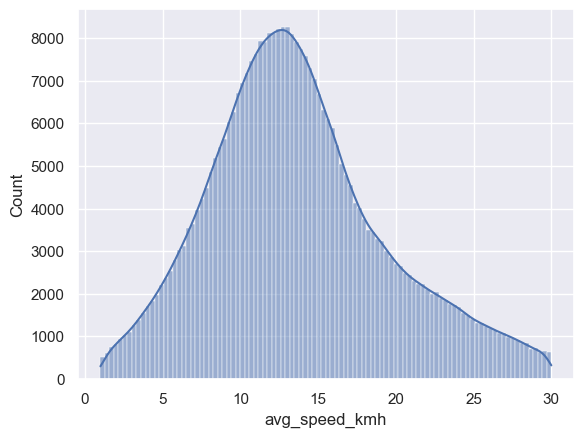

Медиана: 13.13088607788086, среднее: 13.741941452026367


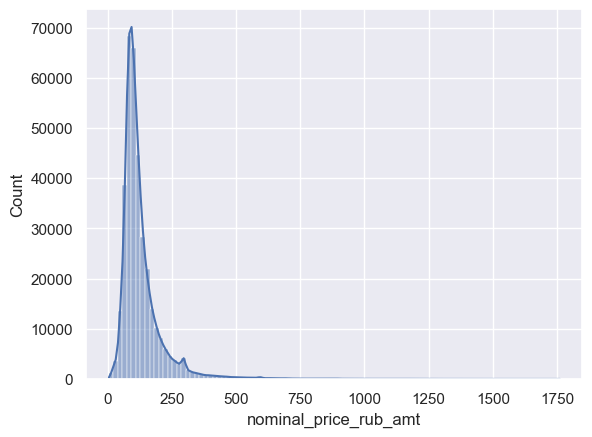

Медиана: 105.93000030517578, среднее: 130.05142211914062


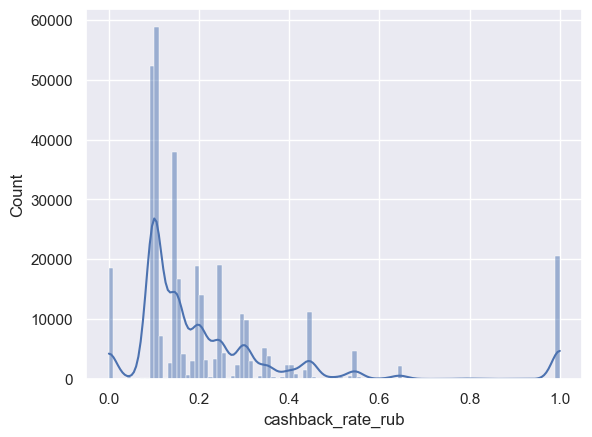

Медиана: 0.14999309182167053, среднее: 0.23185865581035614


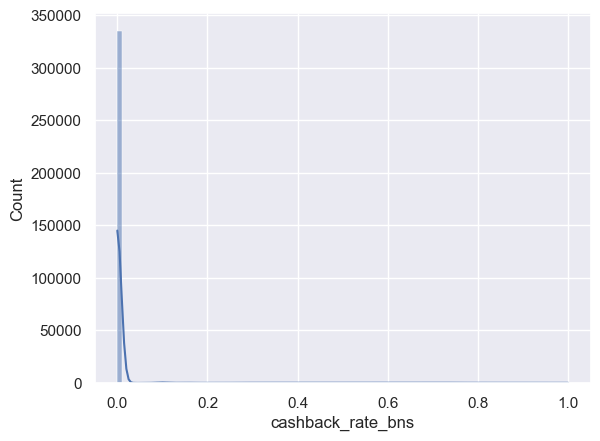

Медиана: 0.0, среднее: 0.02426120825111866


In [42]:
# распределение очищенных данных

columns = ['distance_km', 'trip_duration_min', 'avg_speed_kmh', 'nominal_price_rub_amt', 'cashback_rate_rub', 'cashback_rate_bns']

for col in columns:
    sns.histplot(df[col], bins=100, kde=True)
    plt.show()
    print(f'Медиана: {df[col].median()}, среднее: {df[col].mean()}')

Удалены нереальные значения, сохранены реально редкие случаи.

In [43]:
print(f"Размер очищенного датасета: {df.shape}")

Размер очищенного датасета: (352282, 27)


После очистки данных из 396749 записей осталось 352282, что составляет удаление **11.2%** записей.

### Сохранение очищенных данных

In [44]:
df.to_parquet('../data/cleaned/kicksharing_clean.parquet', index=False)
df.to_csv('../data/cleaned/kicksharing_clean.csv', index=False)

### Результаты очистки

- Данные приведены к корректным типам.
- Добавлено **7** новых столбцов.
- Удалены аномалии и выбросы.
- Количество записей уменьшилось на **11.2%**.
- Данные полностью **очищены** и сохранены в `data/cleaned/kicksharing_clean.csv`. Готовы к исследовательскому анализу (EDA).